In [1]:
import numpy as np
# from brainiak.reconstruct import iem as IEM
import matplotlib.pyplot as plt
import numpy.matlib as matlib
import scipy.signal

In this example, we will assume that the stimuli are circular checkerboards presented in 2-dimensional visual space. We will build an encoding model that has a grid of 6x6 channels, or basis functions, which also span this 2D space.

In [58]:
import iem

In [68]:
import importlib
importlib.reload(iem)

<module 'iem' from '/home/vyvo/projects/brainiak/examples/reconstruct/iem.py'>

In [69]:
# Set up parameters
n_channels = [9, 5]  # channels in the x, y directions
cos_exponent = 5
stimx, stimy = [-17/2, 17/2], [-5, 5]
stim_res = [171, 101]
stim_size = 1.449
chanx, chany = [-6, 6], [-3, 3]
print(stimx, stimy, chanx, chany)

iem_obj = iem.InvertedEncoding2D(stim_xlim=stimx, stim_ylim=stimy,
                                 stimulus_resolution=stim_res,
                                 stim_radius=stim_size,
                                 chan_xlim=chanx, chan_ylim=chany)
# stim_vals = np.linspace(0, feature_resolution - (feature_resolution/6), 6).astype(int)

[-8.5, 8.5] [-5, 5] [-6, 6] [-3, 3]


The quality and interpretability of your stimulus reconstructions all depend on how you set up the channels, or basis functions, in the model. In order to ensure that you can accurately reconstruct stimuli at all portions in the area where you have presented stimuli, you will want to evenly space your basis functions in that region. You also will likely want to ensure some overlap between the basis functions.

There are two pre-built functions to create a 2D grid of basis functions, to use a rectangular grid or a triangular grid. A triangular grid is more space-efficient, so let's use that.

Note you will need to define these basis functions before you can fit the model. Otherwise it will throw an error.

In [70]:
basis_fcns, basis_centers = iem_obj.define_basis_functions_trigrid(grid_radius=3.5)
print(basis_fcns.shape, basis_centers.shape)

(35, 17271, 1) (35, 2)


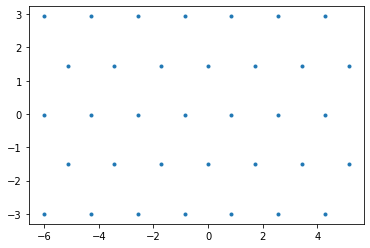

In [71]:
plt.plot(basis_centers[:, 0], basis_centers[:, 1], '.')

To visualize these, you will need to reshape the second dimension into the 2D pixel space where the stimuli are represented.

In [72]:
basis_res = np.reshape(basis_fcns, (basis_fcns.shape[0], stim_res[1], stim_res[0]))

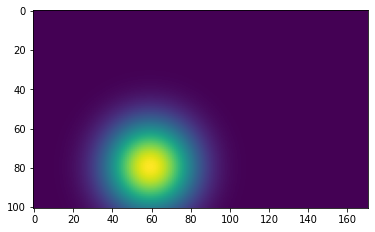

In [73]:
# TODO: create subplots of all of them
plt.imshow(basis_res[30, :, :].squeeze())

In [74]:
# TODO: show summed together basis functions
# TODO: show cross-section of summed basis functions to demonstrate they are flat/smooth

In [75]:
# TODO: load 2D fMRI data...

In [76]:
sx = np.random.randint(0, high=12, size=(20, 1)) - 6
sy = np.random.randint(0, high=6, size=(20, 1)) - 3

C = iem_obj._define_trial_activations(np.hstack((sx, sy)))

(35, 17271, 1)
(17271, 20)


/home/vyvo/projects/brainiak/examples/reconstruct/iem.py:828: RuntimeWarning: Stimulus matrix is 16, not full rank. May cause issues with stimulus prediction/reconstruction.
  np.linalg.matrix_rank(C)), RuntimeWarning)


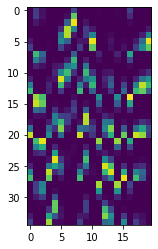

In [78]:
plt.imshow(C)

Now we'll generate synthetic data. Ideally, each voxel that we measure from is roughly tuned to some part of the feature space (see Sprague, Boynton, Serences, 2019). So we will generate data that has a receptive field (RF). We can define the RF along the same feature axis as the channels that we generated above.

The following two functions will generate the voxel RFs, and then generate several trials of that dataset. There are options to add uniform noise to either the RF or the trials.

In [ ]:
# Generate synthetic data s.t. each voxel has a Gaussian tuning function

def generate_voxel_RFs(n_voxels, feature_resolution, random_tuning=True, RF_noise=0.):
    if random_tuning:
        # Voxel selectivity is random
        voxel_tuning = np.floor((np.random.rand(n_voxels) * range_stop) + range_start).astype(int)
    else:
        # Voxel selectivity is evenly spaced along the feature axis
        voxel_tuning = np.linspace(range_start, range_stop, n_voxels+1)
        voxel_tuning = voxel_tuning[0:-1]
        voxel_tuning = np.floor(voxel_tuning).astype(int)
    gaussian = scipy.signal.gaussian(feature_resolution, 15)
    voxel_RFs = np.zeros((n_voxels, feature_resolution))
    for i in range(0, n_voxels):
        voxel_RFs[i, :] = np.roll(gaussian, voxel_tuning[i] - ((feature_resolution//2)-1))
    voxel_RFs += np.random.rand(n_voxels, feature_resolution)*RF_noise  # add noise to voxel RFs
    voxel_RFs = voxel_RFs / np.max(voxel_RFs, axis=1)[:, None]
    
    return voxel_RFs, voxel_tuning


def generate_voxel_data(voxel_RFs, n_voxels, trial_list, feature_resolution, 
                         trial_noise=0.25):
    one_hot = np.eye(feature_resolution)
    # Generate trial-wise responses based on voxel RFs
    if range_start > 0:
        trial_list = trial_list + range_start
    elif range_start < 0:
        trial_list = trial_list - range_start
    stim_X = one_hot[:, trial_list] #@ basis_set.transpose()
    trial_data = voxel_RFs @ stim_X
    trial_data += np.random.rand(n_voxels, trial_list.size)*(trial_noise*np.max(trial_data))
    
    return trial_data

Now let's generate some training data and look at it. This code will create a plot that depicts the response of an example voxel for different trials.

In [ ]:
np.random.seed(100)
n_voxels = 50
n_train_trials = 120
training_stim = np.repeat(stim_vals, n_train_trials/6)
voxel_RFs, voxel_tuning = generate_voxel_RFs(n_voxels, feature_resolution, random_tuning=False, RF_noise=0.1)
train_data = generate_voxel_data(voxel_RFs, n_voxels, training_stim, feature_resolution, trial_noise=0.25)
print(np.linalg.cond(train_data))
# print("Voxels are tuned to: ", voxel_tuning)

# Generate plots to look at the RF of an example voxel.
voxi = 20
f = plt.figure()
plt.subplot(1, 2, 1)
plt.plot(train_data[voxi, :])
plt.xlabel("trial")
plt.ylabel("activation")
plt.title("Activation over trials")
plt.subplot(1, 2, 2)
plt.plot(voxel_RFs[voxi, :])
plt.xlabel("degrees (motion direction)")
plt.axvline(voxel_tuning[voxi])
plt.title("Receptive field at {} deg".format(voxel_tuning[voxi]))
plt.suptitle("Example voxel")

plt.figure()
plt.imshow(train_data)
plt.ylabel('voxel')
plt.xlabel('trial')
plt.suptitle('Simulated data from each voxel')

Using this synthetic training data, we can fit the IEM.

In [ ]:
# Fit an IEM
iem_obj.fit(train_data.transpose(), training_stim)

Calling the IEM fit method defines the channels, or the basis set, which span the feature domain. We can examine the channels and plot them to check that they look appropriate.

Remember that the plot below is in circular space. Hence, the channels wrap around the x-axis. For example, the channel depicted in blue is centered at 0 degrees (far left of plot), which is the same as 360 degrees (far right of plot).

We can check whether the channels properly tile the feature space by summing across all of them. This is shown on the right plot. It should be a straight horizontal line.

In [ ]:
# Let's visualize the basis functions.
channels = iem_obj.channels_
feature_axis = iem_obj.channel_domain
print(channels.shape)

plt.figure()
plt.subplot(1, 2, 1)
for i in range(0, channels.shape[0]):
    plt.plot(feature_axis, channels[i,:])
plt.title('Channels (i.e. basis functions)')
plt.subplot(1, 2, 2)
plt.plot(np.sum(channels, 0))
plt.ylim(0, 2.5)
plt.title('Sum across channels')

Now we can generate test data and see how well we can predict the test stimuli.

In [ ]:
# Generate test data
n_test_trials = 12
test_stim = np.repeat(stim_vals, n_test_trials/len(stim_vals))
np.random.seed(330)
test_data = generate_voxel_data(voxel_RFs, n_voxels, test_stim, feature_resolution, trial_noise=0.25)

In [ ]:
# Predict test stim & get R^2 score
pred_feature = iem_obj.predict(test_data.transpose())
R2 = iem_obj.score(test_data.transpose(), test_stim)

print("Predicted features are: {} degrees.".format(pred_feature))
print("Actual features are: {} degrees.".format(test_stim))
print("Test R^2 is {}".format(R2))

In addition to predicting the exact feature, we can examine the model-based reconstructions in the feature domain. That is, instead of getting single predicted values for each feature, we can look at a reconstructed function which peaks at the predicted feature.

Below we will plot all of the reconstructions. There will be some variability because of the noise added during the synthetic data generation.

In [ ]:
# Now get the model-based reconstructions, which are continuous
# functions that should peak at each test stimulus feature
recons = iem_obj._predict_feature_responses(test_data.transpose())

f = plt.figure()
for i in range(0, n_test_trials-1):
    plt.plot(feature_axis, recons[:, i])
for i in stim_vals:
    plt.axvline(x=i, color='k', linestyle='--')

plt.title("Reconstructions of {} degrees".format(np.unique(test_stim)))

For a sanity check, let's check how R^2 changes as the number of voxels increases. We can write a quick wrapper function to train and test on a given set of motion directions, as below.

In [ ]:
iem_obj.verbose = False
def train_and_test(nvox, ntrn, ntst, rfn, tn):
    vRFs, vox_tuning = generate_voxel_RFs(nvox, feature_resolution, random_tuning=True, RF_noise=rfn)
    trn = np.repeat(stim_vals, ntrn/6).astype(int)
    trnd = generate_voxel_data(vRFs, nvox, trn, feature_resolution, trial_noise=tn)
    tst = np.repeat(stim_vals, ntst/6).astype(int)
    tstd = generate_voxel_data(vRFs, nvox, tst, feature_resolution, trial_noise=tn)
    
    iem_obj.fit(trnd.transpose(), trn)
    recons = iem_obj._predict_feature_responses(tstd.transpose())
    pred_ori = iem_obj.predict(tstd.transpose())
    R2 = iem_obj.score(tstd.transpose(), tst)

    return recons, pred_ori, R2, tst

We'll iterate through the list and look at the resulting R^2 values.

In [ ]:
np.random.seed(300)
vox_list = (5, 10, 15, 25, 50)
R2_list = np.zeros(len(vox_list))
for idx, nvox in enumerate(vox_list):
    recs, preds, R2_list[idx], test_features = train_and_test(nvox, 120, 30, 0.1, 0.25)

print("The R2 values for increasing numbers of voxels: ")
print(R2_list)